# Stationary behaviour of EIP 1559 agent-based model

###### July 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

We introduce here the building blocks of agent-based simulations of EIP1559. All the code is available in [this repo](https://github.com/barnabemonnot/abm1559), with some preliminary documentation [here](https://barnabemonnot.com/abm1559/build/html/).

## The broad lines

We have several entities. _Users_ come in randomly (following a Poisson process) and create and send transactions. The transactions are received by a _transaction pool_, from which the $x$ best _valid_ transactions are included in a _block_ created at fixed intervals. $x$ depends of how many valid transactions exist in the pool (e.g., how many post a gasprice exceeding the prevailing basefee in 1559 paradigm) and the block gas limit. Once transactions are included in the block, and the block is included in the _chain_, transactions are removed from the transaction pool.

How do users set their parameters? Users have their own internal ways of evaluating their costs, detailed below. Users obtain a certain value from having their transaction included, which we call $v$. This value is fixed but their overall payoff decreases the longer they wait to be included. Some users have higher time-preferences than others, and their payoff decreases faster than others the longer they wait.

Users expect to wait for a certain amount of time. In this essay, we set this to a fixed value -- somewhat arbitrarily we chose 5. This can be readily understood in the following way. Users estimate what their payoff will be from getting included 5 blocks from now, assuming basefee remains constant. If this payoff is negative, i.e., if their value minus the cost incurred from the wait is negative, they decide not to send the transaction to the pool (in queuing terminology, they _balk_).

The scenario is set up this way to study _stationarity_: assuming some demand comes in from a fixed distribution at regular intervals, we must expect basefee to reach some stationary value. It is enough then for users, at this stationary point, to consider that 5 blocks from now basefee will still be at the same level. In the nonstationary case, when for instance a systemic change in the demand happens (e.g., the rate of Poisson arrivals increases), a user may want to hedge their bets by estimating their future payoffs in a different way, taking into account that basefee might increase instead.

We make the assumption here that users choose their 1559 parameters based on their value alone. We set the transaction `max_fee` parameter to the value of the user and the `gas_premium` parameter is set to a residual value, here 1 Gwei per unit of gas. There is no loss of generality in assuming all users send the same transaction in (e.g., a simple transfer) and so all transactions have the same `gas_used` value. In 1559 paradigm, with a 20M gas limit per block, this allows at most 952 transactions to be included.

## Simulation

We import a few classes from our `abm1559` package.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_demand,
    decide_transactions,
    update_basefee,
)

import pandas as pd

This is the main function used to simulate the fee market. It takes in a `demand_scenario` array. We've seen that each round, we draw the number of users wishing to send transactions from a Poisson distribution. [This distribution is parameterised by the expected number of arrivals, called _lambda_ $\lambda$](https://en.wikipedia.org/wiki/Poisson_distribution). The `demand_scenario` array contains a sequence of such lambda's. We also provide in `UserClass` the type of user we would like to model (see the [docs]() for more details).

In [2]:
def simulate(demand_scenario, UserClass):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []

    for t in range(len(demand_scenario)):
        if t % 100 == 0: print(t)

        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
        }

        # We return some demand which on expectation yields 2000 new users per round
        users = spawn_poisson_demand(t, demand_scenario[t], UserClass)

        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "timestep": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "blk_avg_waiting_time": block.average_waiting_time(),
            "pool_length": txpool.pool_length,
            "pool_avg_gas_price": txpool.average_gas_price(params),
            "pool_avg_tip": txpool.average_tip(params),
            "pool_avg_waiting_time": txpool.average_waiting_time(t),
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return pd.DataFrame(metrics)

To study the stationary case, we start with an array containing the same value for as many time steps as we wish to simulate the market for. We'll set that value to expecting 2000 users spawning between two blocks, for 200 timesteps.

In [3]:
demand_scenario = [2000 for i in range(200)]
df = simulate(demand_scenario, User1559)

0
100


## Results

Let's print the head and tail of the data frame holding our metrics. Each row corresponds to one round of our simulation, so one block.

In [4]:
df

,timestep,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,blk_avg_waiting_time,pool_length,pool_avg_gas_price,pool_avg_tip,pool_avg_waiting_time
0,0,1.000000,2056,1624,952,2.000000,1.0,0.000000,672,2.000000,1.000000,0.000000
1,1,1.124900,1934,1474,952,2.124900,1.0,0.705882,1194,2.124900,1.000000,0.000000
2,2,1.265400,1932,1460,952,2.265400,1.0,1.000000,1702,2.265400,1.000000,0.142186
3,3,1.423448,1987,1492,952,2.423448,1.0,1.254202,2242,2.423396,0.999948,0.334523
4,4,1.601237,1965,1449,952,2.601237,1.0,1.786765,2739,2.601130,0.999892,0.471340
...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,11.703537,1909,468,468,12.703537,1.0,0.000000,1606,8.749221,-2.954315,181.661893
196,196,11.678374,2006,452,452,12.678374,1.0,0.000000,1606,8.749221,-2.929153,182.661893
197,197,11.604216,1991,473,473,12.604216,1.0,0.000000,1606,8.749221,-2.854995,183.661893
198,198,11.594498,2042,492,492,12.594498,1.0,0.000000,1606,8.749221,-2.845277,184.661893


At the start of the simulation we clearly see in column `users` a demand around 2000 users per round. Among these 2000 or so, around 1500 decide to send their transaction in (`decided_txs`). Eventually 952 of them are included (`included_txs`), maxing out the block gas limit. The basefee starts at 1 Gwei but steadily increases from there.

By the end of the simulation, we note that `decided_txs` is always equal to `included_txs`. By this point, the basefee has risen enough to make most users find sending their transaction is unprofitable. This is exactly what we want! Users balk at the current prices.

In the next chart we show the evolution of basefee and gas price. We define _tip_ as the gas price minus the basefee. Note that [it is in general **not** equal to the gas premium](https://twitter.com/barnabemonnot/status/1284271520311848960) that users set, in particular when basefee plus gas premium exceeds the max fee of the user. In the graph below, the tip hovers around 1 Gwei (the premium), but is sometimes less than 1 too, especially when users see their posted max fees approached by the prevailing basefee.

<AxesSubplot:xlabel='timestep'>

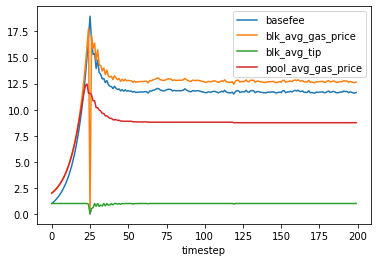

In [5]:
df.plot("timestep", ["basefee", "blk_avg_gas_price", "blk_avg_tip", "pool_avg_gas_price"])

Notice the increase at the beginning followed by a short drop? At the very beginning, the pool fills up quickly with many users hopeful to get their transactions in with a positive resulting payoff. The basefee increases until users start balking **and** the pool is exhausted. Once exhausted, basefee starts decreasing again to settle at the stationary point where the pool only includes transactions that are invalid given the stationary basefee (see also the average gas price of transaction in the pool, with the red line well below the basefee even).

We can see the pool length becoming stationary in the next plot, showing the length of the pool over time.

<AxesSubplot:xlabel='timestep'>

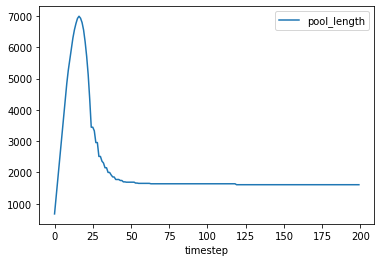

In [6]:
df.plot("timestep", "pool_length")

Remaining transactions are likely from early users who did not balk even though basefee was increasing, and who were quickly outbid by others.

## Demand shock

We look at a stationary setting, where the new demand coming in each new round follows a fixed expected rate of arrival. Demand shocks may be of two kinds:

- Same number of users, different values for transactions and costs for waiting.
- Increased number of users, same values and costs.

We'll consider the second scenario here, simply running the simulation again and increasing the parameter of our Poisson arrival process suddenly, from expecting 2000 users per round to 6000.

In [7]:
demand_scenario = [2000 for i in range(100)] + [6000 for i in range(100)]
df_jump = simulate(demand_scenario, User1559)

0
100


<AxesSubplot:xlabel='timestep'>

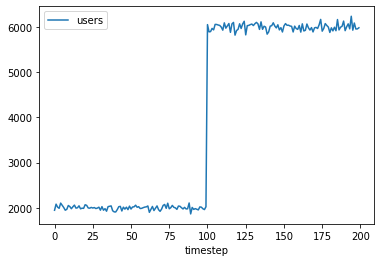

In [8]:
df_jump.plot("timestep", "users")

<AxesSubplot:xlabel='timestep'>

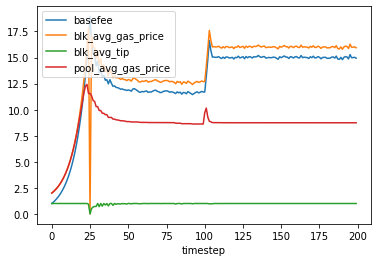

In [9]:
df_jump.plot("timestep", ["basefee", "blk_avg_gas_price", "blk_avg_tip", "pool_avg_gas_price"])

We see a jump around timestep 200, when the arrival rate of users switches from 2000 to 6000. Basefee increases in response. With a block limit of 20M gas, about 950 transactions fit in each block. Targetting half of this value, basefee increases until more or less 475 transactions are included in each block.

Since our users' values and costs are always drawn from the same distribution, we expect when 2000 users show up to let in about 25% of them (~ 475 / 2000), the 25% with greatest expected payoff should they wait 5 blocks to get in. When 6000 users come in, we now expect the 8% (~ 475 / 6000) "richest" to get in only, so we obviously "raise the bar" for the basefee, since we need to discriminate more.

<AxesSubplot:xlabel='timestep'>

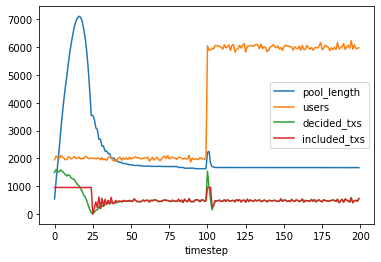

In [10]:
df_jump.plot("timestep", ["pool_length", "users", "decided_txs", "included_txs"])

As we see with the graph above, for a short while blocks include more than the usual ~475 transactions: since we have a whole bunch of new users, more of them are willing and able to pay for their transactions above the basefee, and thus get included.

In [14]:
df_jump.tail()

,timestep,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,blk_avg_waiting_time,pool_length,pool_avg_gas_price,pool_avg_tip,pool_avg_waiting_time
195,195,15.281417,5931,403,403,16.281417,1.0,0.0,1667,8.742472,-6.538946,179.95081
196,196,14.987823,6089,478,478,15.987823,1.0,0.0,1667,8.742472,-6.245351,180.95081
197,197,14.994942,5957,483,483,15.994942,1.0,0.0,1667,8.742472,-6.252471,181.95081
198,198,15.021746,5959,455,455,16.021746,1.0,0.0,1667,8.742472,-6.279274,182.95081
199,199,14.938187,5984,553,553,15.938187,1.0,0.0,1667,8.742472,-6.195716,183.95081


## Changing expected time

Next block inclusion!

In [11]:
class OptiUser(User1559):
    def expected_time(self, params):
        return 1
    
df_opti = simulate(demand_scenario, OptiUser)

0
100


<AxesSubplot:xlabel='timestep'>

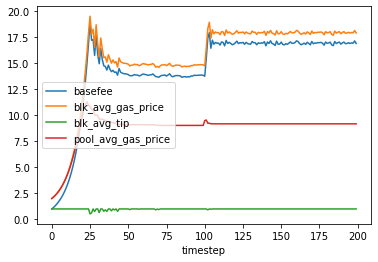

In [12]:
df_opti.plot("timestep", ["basefee", "blk_avg_gas_price", "blk_avg_tip", "pool_avg_gas_price"])

In [13]:
df_opti.tail()

,timestep,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,blk_avg_waiting_time,pool_length,pool_avg_gas_price,pool_avg_tip,pool_avg_waiting_time
195,195,16.867138,6019,490,490,17.867138,1.0,0.0,6050,9.165198,-7.701939,179.536198
196,196,16.928281,6007,469,469,17.928281,1.0,0.0,6050,9.165198,-7.763083,180.536198
197,197,16.896329,5918,526,526,17.896329,1.0,0.0,6050,9.165198,-7.731131,181.536198
198,198,17.117248,5955,422,422,18.117248,1.0,0.0,6050,9.165198,-7.952050,182.536198
199,199,16.873755,5813,453,453,17.873755,1.0,0.0,6050,9.165198,-7.708557,183.536198
